# Notebook setup

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


import numpy as np
import matplotlib.pyplot as plt

import os
import sys

sys.path.insert(1, '../')

from moments_toolkit import moments_toolkit

# Data reading

In [2]:
p3fold = os.environ['mount_point_path'] + "48c48/binned_1012_hmz370_BMW/3PointCorrelation/"
p2fold = os.environ['mount_point_path'] + "48c48/binned_1012_hmz370_BMW/2PointCorrelation/"


opAnalyzer = moments_toolkit(p3fold, p2fold,
                            T_to_remove_list=[12], skip3p=False, skipop=False,
                            verbose=True,
                            fast_data_folder = "../fast_data",
                            operator_folder= "../operator_database",
                            max_n=3)


Initializing the moments_toolkit class instance...


Initializing the building block class instance...


Reading the the keys of the dataset ...


Reading the 2 point and 3 point correlators from the fast access dataset ...


Reading the list of all the available operators from the database...


Class Initialization Complete!



# Ratio Plot - Attempt 1

## Operator selection

In [3]:
#we take the operators of the paper

opV1 = 1/6 * opAnalyzer.get_operator(2)
opV2 = 1/(3 * np.sqrt(2)) * (opAnalyzer.get_operator(2) - opAnalyzer.get_operator(3))
opV3 = 1/np.sqrt(2) * opAnalyzer.get_operator(14)

opA1 = 1/np.sqrt(2) * opAnalyzer.get_operator(28)
opA2 = 1/np.sqrt(2) * opAnalyzer.get_operator(32)

opT1 = opAnalyzer.get_operator(74) + 1/2 * opAnalyzer.get_operator(78)
opT2 = opAnalyzer.get_operator(78)
opT3 =  1/6 * ( -3 * opAnalyzer.get_operator(83) + 2 * opAnalyzer.get_operator(87) + 3* opAnalyzer.get_operator(91) + opAnalyzer.get_operator(95) )
opT4 = 1/2 * ( opAnalyzer.get_operator(83) + 2 * opAnalyzer.get_operator(87) -2* opAnalyzer.get_operator(91) )

In [4]:
"V"
(opV1*6).O
(opV2*np.sqrt(2)).O
(opV3*np.sqrt(2)).O
"A"
(opA1*np.sqrt(2)).O
(opA2*np.sqrt(2)).O
"T"
opT1.O
opT2.O
opT3.O
opT4.O

'V'

1.0*O[1, 1] + 1.0*O[2, 2] + 1.0*O[3, 3] - 3.0*O[4, 4]

1.0*O[3, 3] - 1.0*O[4, 4]

1.0*O[1, 4] + 1.0*O[4, 1]

'A'

1.0*O[1, 3] + 1.0*O[3, 1]

1.0*O[3, 4] + 1.0*O[4, 3]

'T'

1.0*O[2, 1, 1] - 1.0*O[2, 4, 4]

1.0*O[2, 3, 3] - 1.0*O[2, 4, 4]

1.0*O[1, 2, 4] - 1.0*O[2, 4, 1]

1.0*O[1, 4, 2] - 2.0*O[2, 1, 4] + 1.0*O[4, 2, 1]

In [5]:
#(2* opAnalyzer.get_operator(87)).O
#opAnalyzer.get_operator(91).O
#opAnalyzer.get_operator(95).O
#
#
#
#2 * opAnalyzer.get_operator(87) - 2 * opAnalyzer.get_operator(95) + 3 * opAnalyzer.get_operator(83)
#
#
#
#
#opAnalyzer.get_operator(83).O
#(2 * opAnalyzer.get_operator(87)).O
#opAnalyzer.get_operator(91).O
#opAnalyzer.get_operator(95).O
#
#
#
#
#(-3 * opAnalyzer.get_operator(83)).O
#(2 * opAnalyzer.get_operator(87)).O
#(3* opAnalyzer.get_operator(91)).O
#opAnalyzer.get_operator(95).O
#
#
#(-3 * opAnalyzer.get_operator(83) + 2 * opAnalyzer.get_operator(87) + 3* opAnalyzer.get_operator(91) + opAnalyzer.get_operator(95) ).O
#
#
#
#( opAnalyzer.get_operator(83) + 2 * opAnalyzer.get_operator(87) -2* opAnalyzer.get_operator(91) ).O

In [6]:
#we empty the selected op just to be sure
opAnalyzer.deselect_operator()

#we append the operators
opAnalyzer.append_operator(opV1)
opAnalyzer.append_operator(opV2)
opAnalyzer.append_operator(opV3)
opAnalyzer.append_operator(opA1)
opAnalyzer.append_operator(opA2)
opAnalyzer.append_operator(opT1)
opAnalyzer.append_operator(opT2)
opAnalyzer.append_operator(opT3)
opAnalyzer.append_operator(opT4)

opAnalyzer.selected_op

[O[1, 1]/6 + O[2, 2]/6 + O[3, 3]/6 - O[4, 4]/2,
 707106781186547*O[3, 3]/1000000000000000 - 707106781186547*O[4, 4]/1000000000000000,
 707106781186547*O[1, 4]/1000000000000000 + 707106781186547*O[4, 1]/1000000000000000,
 707106781186547*O[1, 3]/1000000000000000 + 707106781186547*O[3, 1]/1000000000000000,
 707106781186547*O[3, 4]/1000000000000000 + 707106781186547*O[4, 3]/1000000000000000,
 O[2, 1, 1] - O[2, 4, 4],
 O[2, 3, 3] - O[2, 4, 4],
 O[1, 2, 4] - O[2, 4, 1],
 O[1, 4, 2] - 2*O[2, 1, 4] + O[4, 2, 1]]

In [7]:
from building_blocks_reader import gamma_mu, gamma5, gamma_to_list, gamma_to_key, list_to_key
from building_blocks_reader import gamma_prod

In [8]:
from kinematic_data import gamma1, gamma2, gamma3, gamma4

gamma1 * gamma2 * gamma3 * gamma4

gamma1 * gamma1
gamma1 * gamma2
gamma2 * gamma1

Matrix([
[1, 0,  0,  0],
[0, 1,  0,  0],
[0, 0, -1,  0],
[0, 0,  0, -1]])

Matrix([
[1, 0, 0, 0],
[0, 1, 0, 0],
[0, 0, 1, 0],
[0, 0, 0, 1]])

Matrix([
[-I, 0,  0, 0],
[ 0, I,  0, 0],
[ 0, 0, -I, 0],
[ 0, 0,  0, I]])

Matrix([
[I,  0, 0,  0],
[0, -I, 0,  0],
[0,  0, I,  0],
[0,  0, 0, -I]])

In [9]:
#for the axial case we have to take the product of each gamma mu with gamma5
for mu, gamma in enumerate(gamma_mu):

    #we look at what is the result of the product gamma_mu * gamma5 (both in overall sign and in gamma structure)
    sign_result, list_result = gamma_prod( gamma_to_list[gamma], gamma_to_list[gamma5]  )
    
    f" {gamma} * {gamma5} = {sign_result, list_to_key(list_result)}"

" gamma1 * gamma5 = (1, 'g14')"

" gamma2 * gamma5 = (-1, 'g13')"

" gamma3 * gamma5 = (1, 'g11')"

" gamma4 * gamma5 = (-1, 'g7')"

In [10]:
for mu, gamma in enumerate(gamma_mu):
    gamma_to_key[gamma]
    opAnalyzer.dstructure_list.index(gamma_to_key[gamma])

'g1'

1

'g2'

8

'g4'

10

'g8'

14

In [11]:
opAnalyzer.dstructure_list

['g0',
 'g1',
 'g10',
 'g11',
 'g12',
 'g13',
 'g14',
 'g15',
 'g2',
 'g3',
 'g4',
 'g5',
 'g6',
 'g7',
 'g8',
 'g9']

In [12]:
my_nice_variable_name = 'test'
f'{opV1=}'.split("=")[0]
print(f'{my_nice_variable_name=}')

'opV1'

my_nice_variable_name='test'


In [13]:
from kinematic_data import I

In [14]:
opA1.O
opA1.K
I in opA1.K.atoms()
opA2.O
opA2.K
I in opA2.K.atoms()

0.707106781186547*O[1, 3] + 0.707106781186547*O[3, 1]

707106781186547*I*p_1*(E(p)*m_N + m_N**2 + 2*p_3**2)/(1000000000000000*E(p)*(E(p) + m_N))

True

0.707106781186547*O[3, 4] + 0.707106781186547*O[4, 3]

707106781186547*(-E(p)**3 - 2*E(p)**2*m_N - E(p)*m_N**2 + E(p)*p_1**2 + E(p)*p_2**2 - 3*E(p)*p_3**2 - 2*m_N*p_3**2)/(2000000000000000*E(p)*(E(p) + m_N))

False

## Ratios

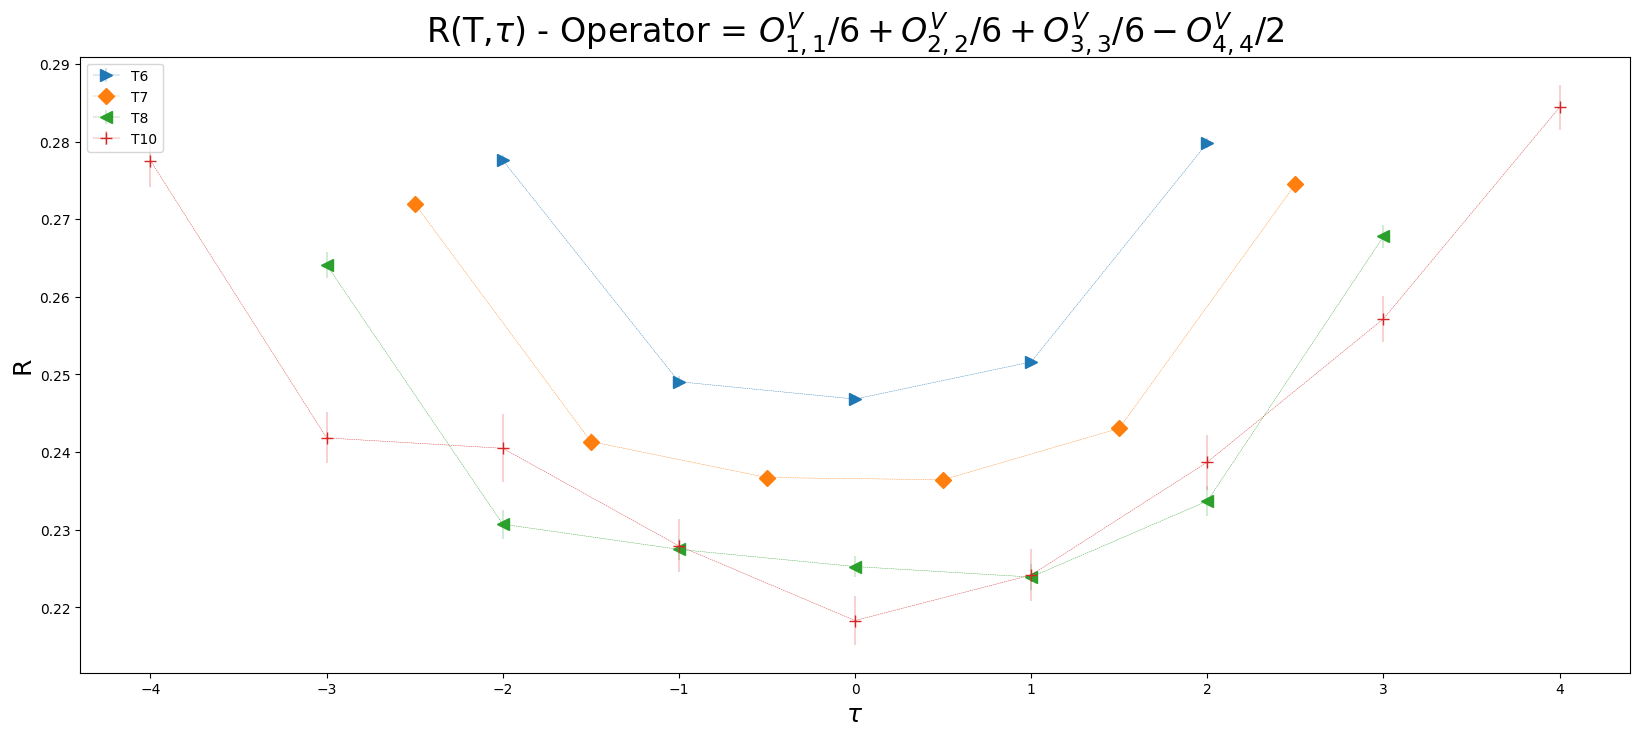

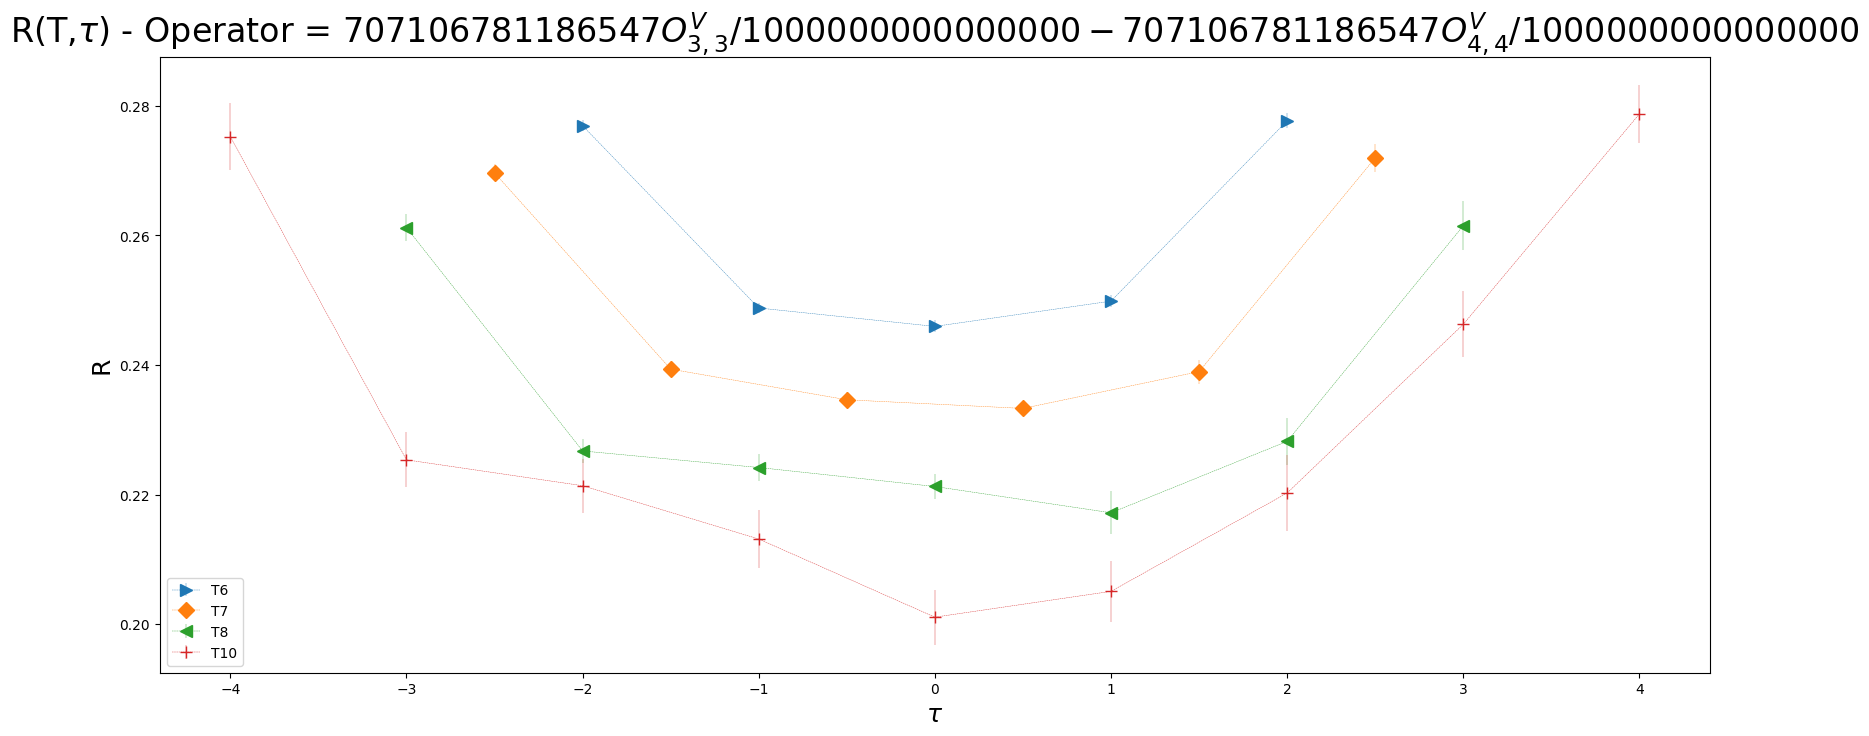

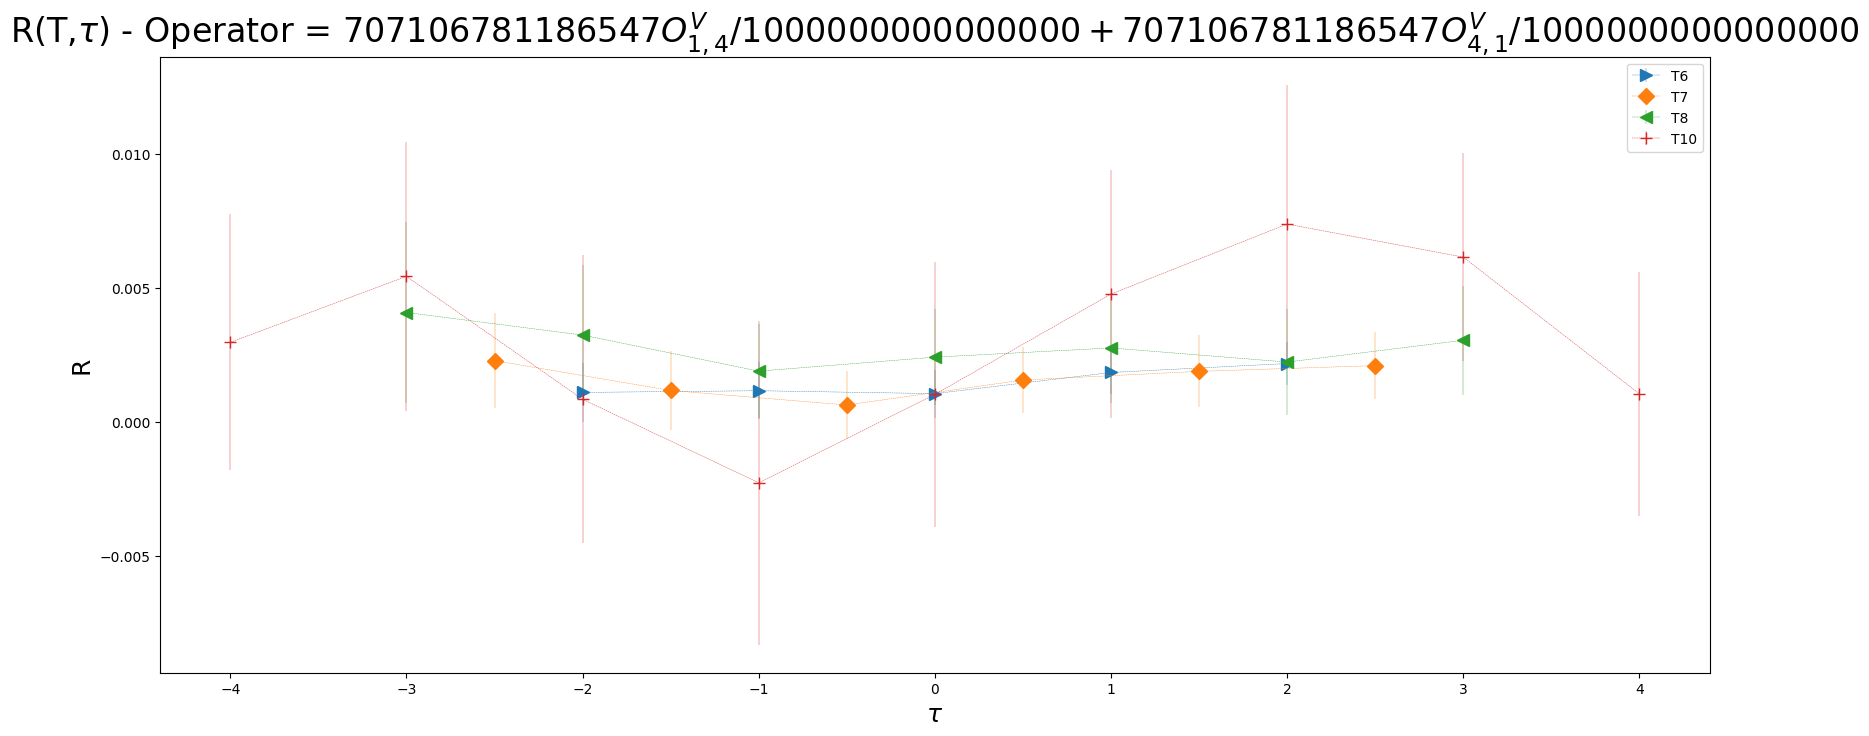

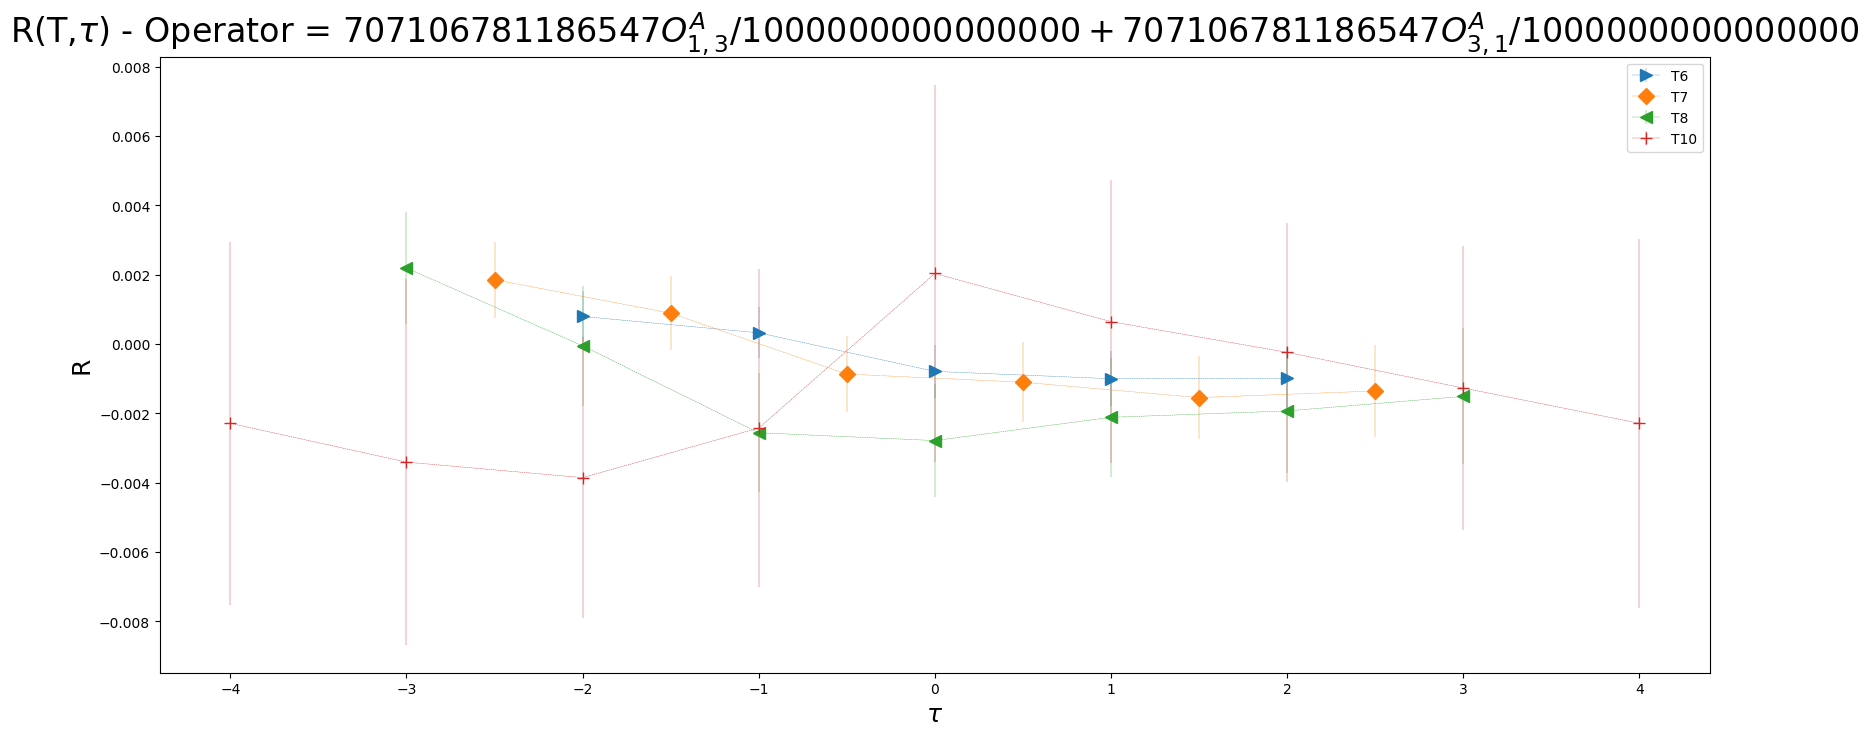

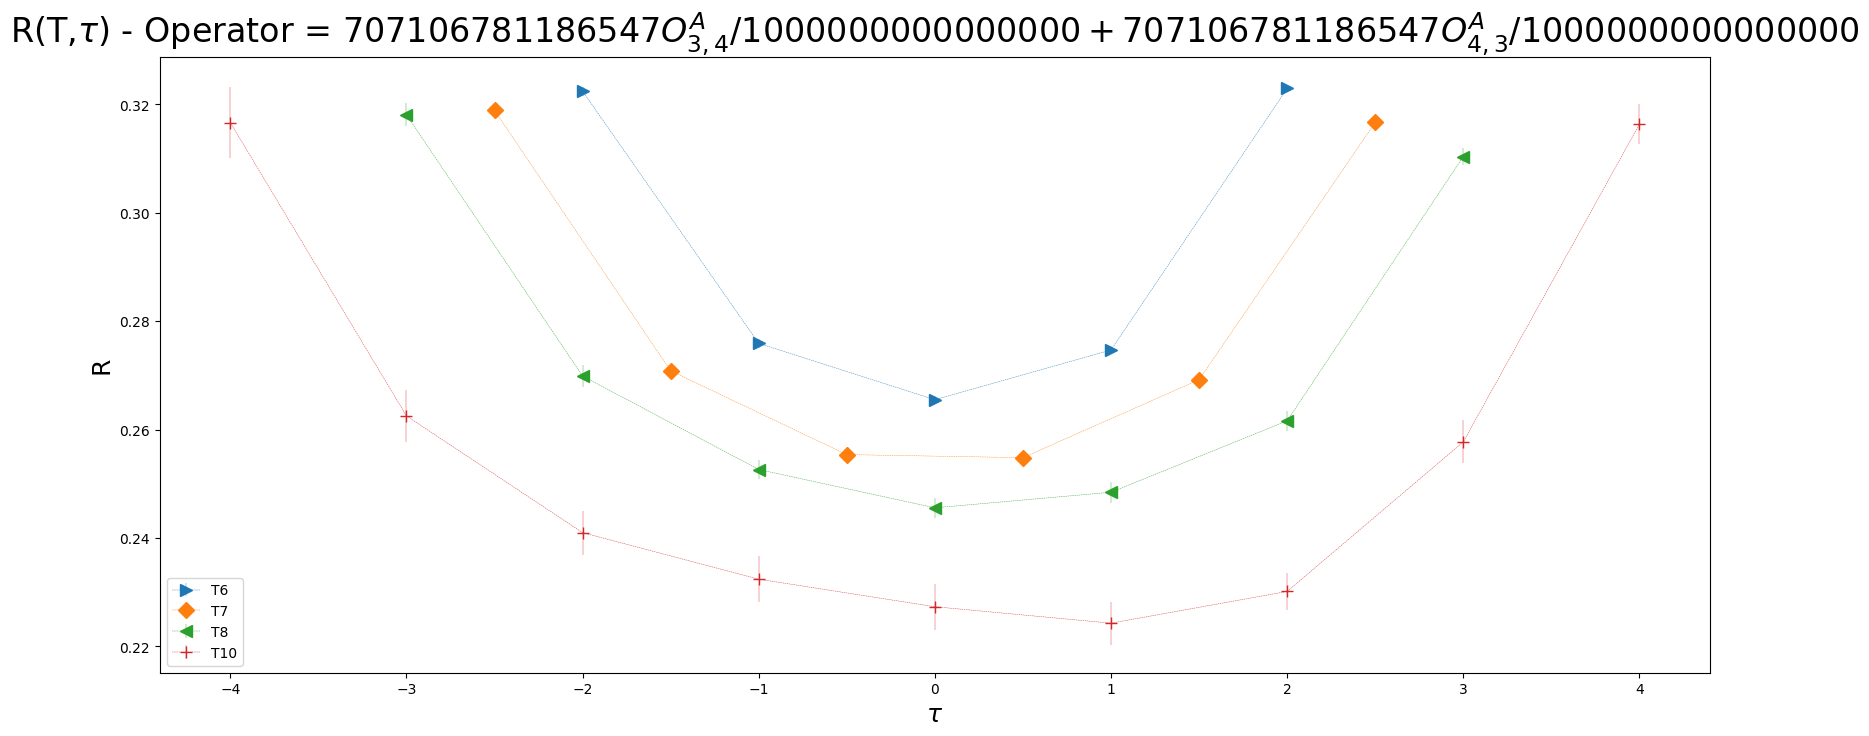

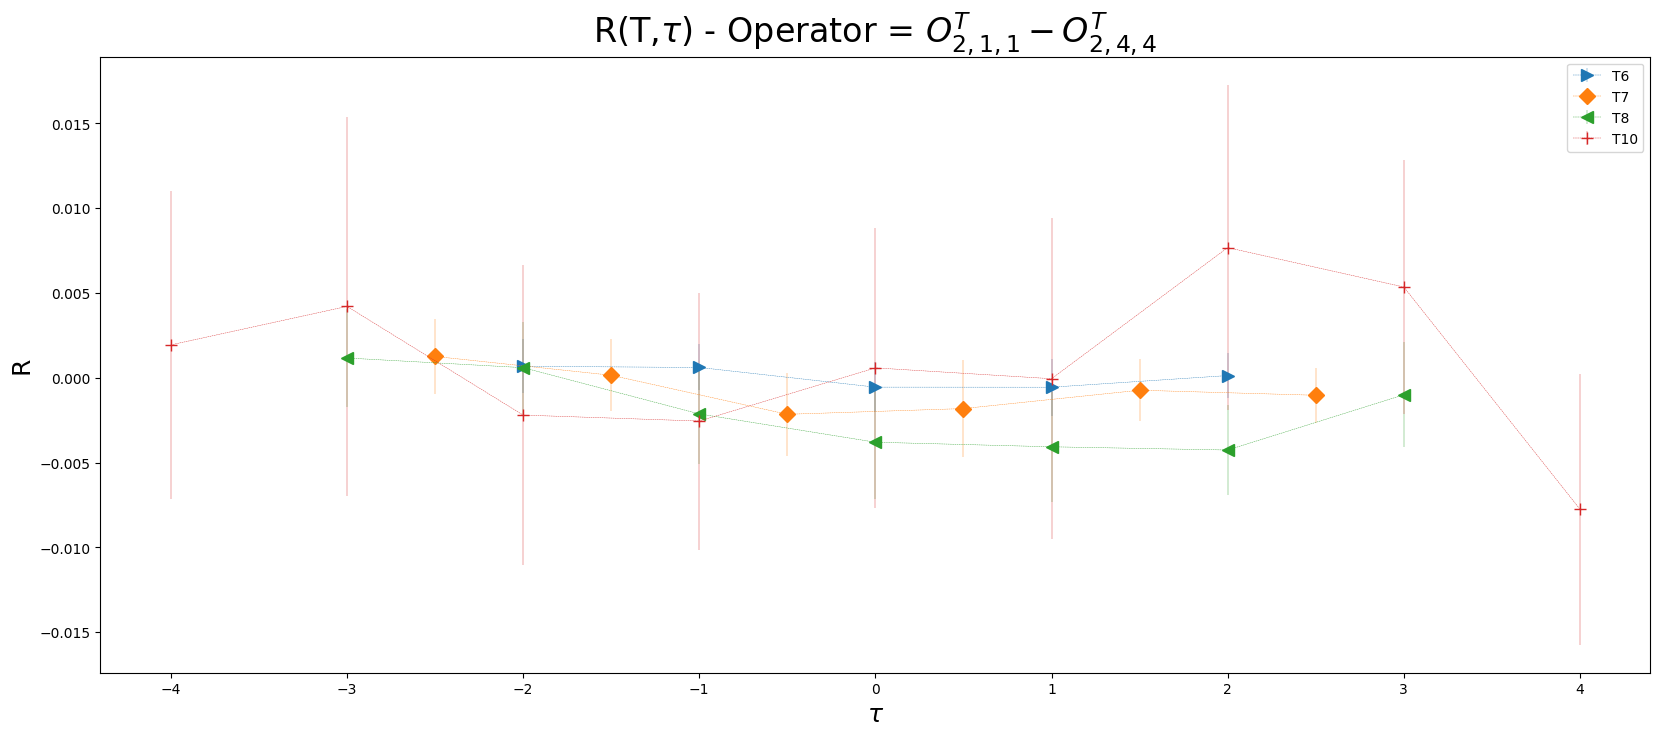

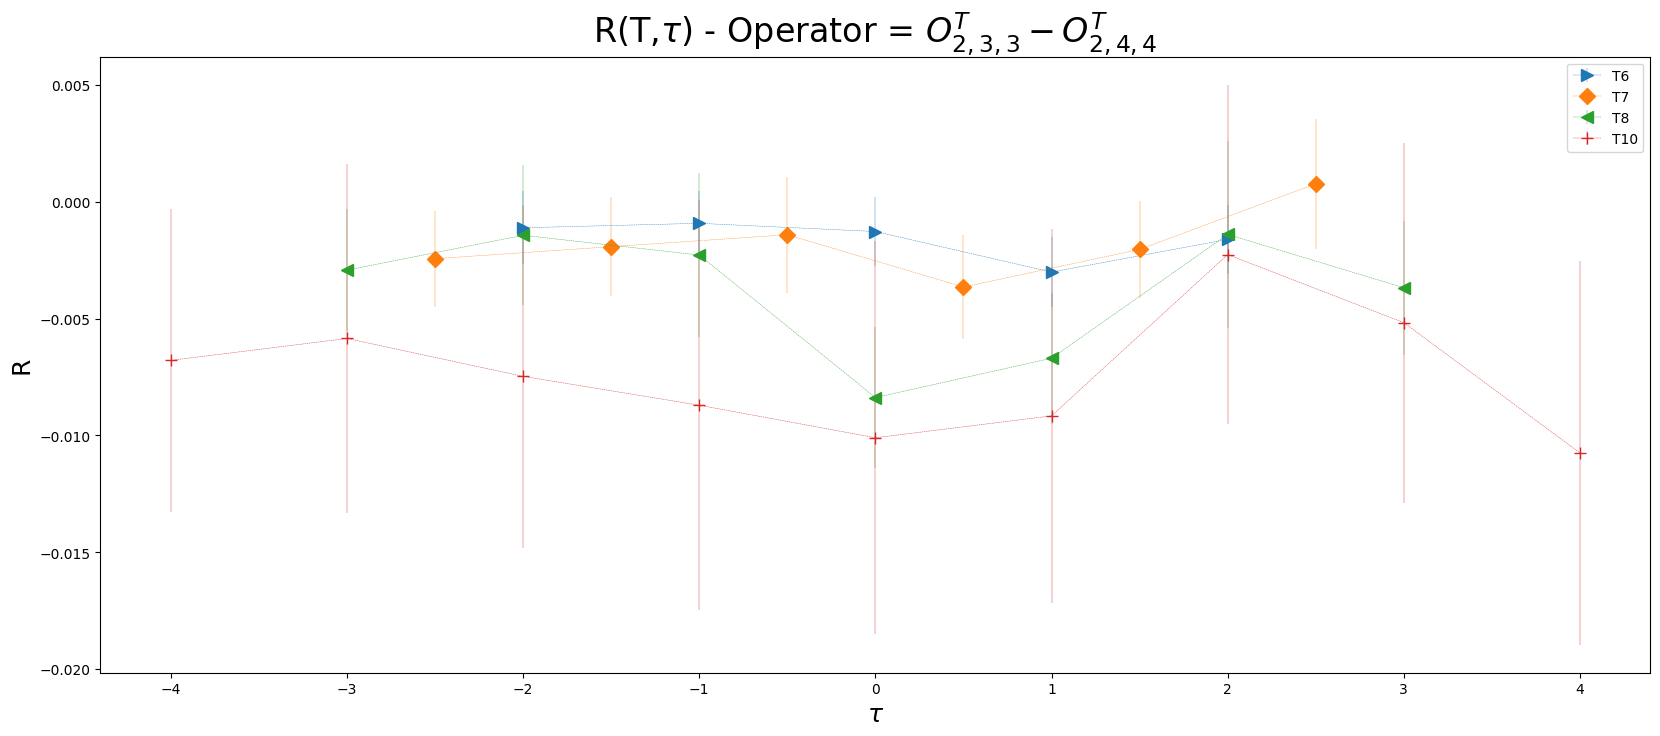

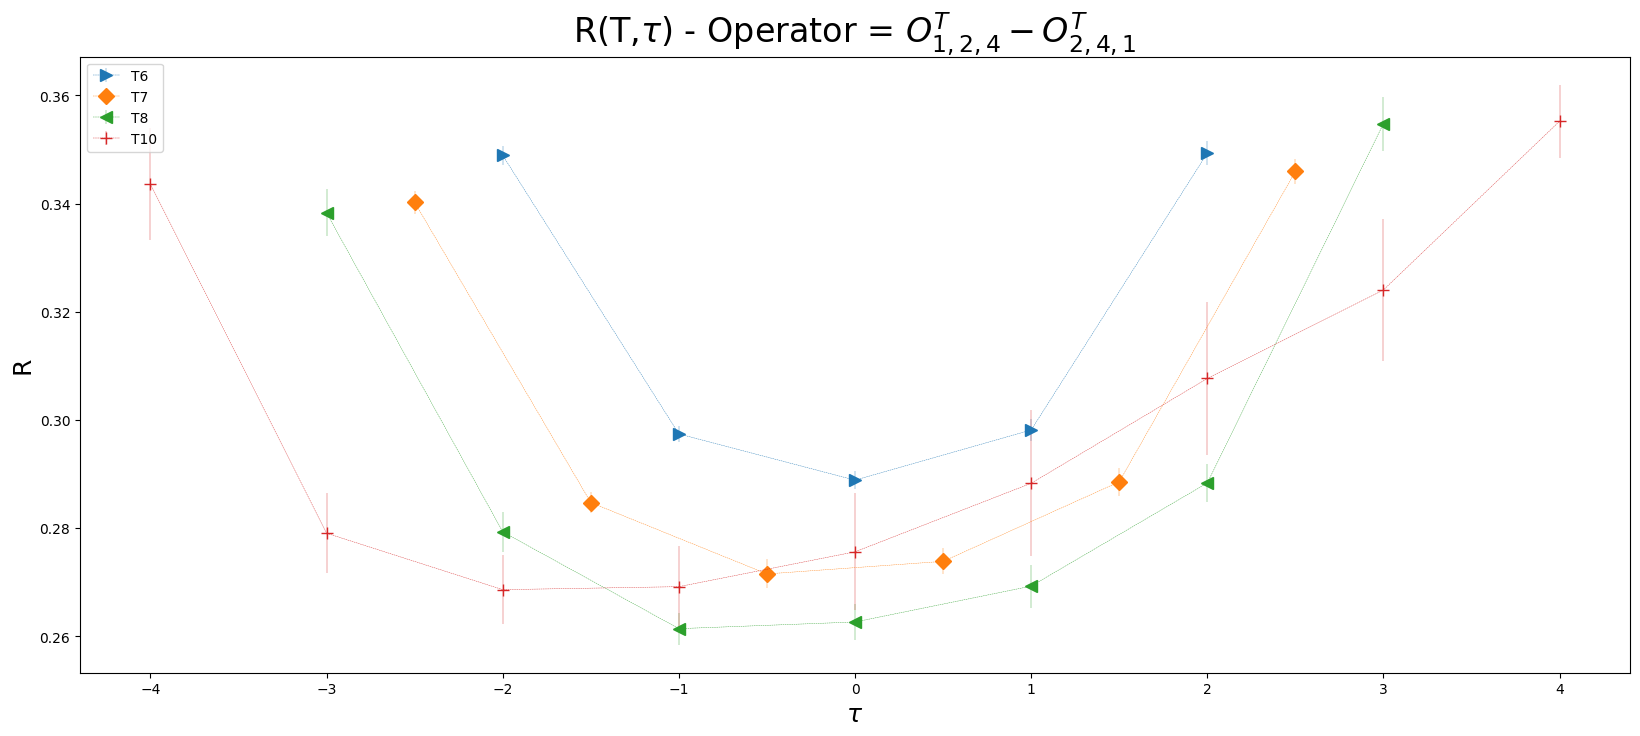

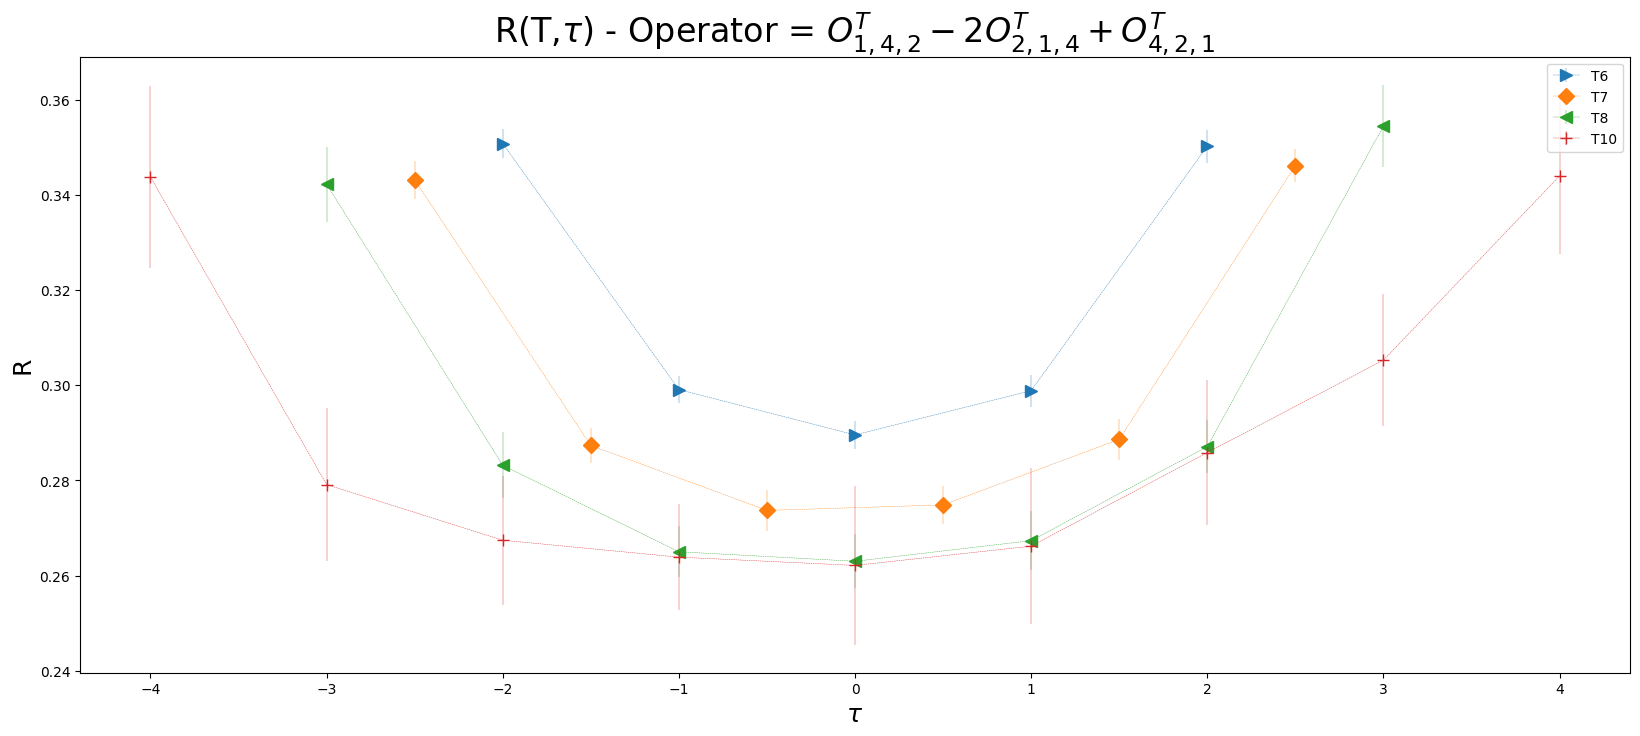

In [15]:
opAnalyzer.plot_R(rescale=True)

In [16]:
fit_state = opAnalyzer.fit_2pcorr(zoom=5,show=False,save=False)

In [17]:
par = fit_state.model_average()
par.keys()
par['est']['E0']


a = 0.1163

par['est']['E0'] /a * 197.327

1000/197.327 * a

dict_keys(['est', 'err'])

np.float64(0.6987413871543884)

np.float64(1185.559257979484)

0.5893770239247543